In [47]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

## Data Prep

In [3]:
divisions = gpd.read_file(
    r"C:/Users/jackr/Documents/Dev/Hot-Cold-Simulation/data/USA_Divisions/usa_divisions.shp"
)
counties = gpd.read_file(
    r"C:/Users/jackr/Documents/Dev/Hot-Cold-Simulation/data/USA_Counties/usa_counties.shp"
)
states = gpd.read_file(
    r"C:/Users/jackr/Documents/Dev/Hot-Cold-Simulation/data/USA_States/usa_states.shp"
)

In [4]:
print(divisions)

             division                                           geometry
0         New England  MULTIPOLYGON (((-71.67381 41.17886, -71.67281 ...
1     Middle Atlantic  POLYGON ((-75.01591 38.79016, -75.01611 38.790...
2  East North Central  POLYGON ((-91.16348 40.64893, -91.15913 40.651...
3  West North Central  POLYGON ((-91.41982 40.37791, -91.42018 40.377...
4      South Atlantic  MULTIPOLYGON (((-82.97774 24.65649, -82.96410 ...
5  East South Central  POLYGON ((-90.95847 34.12511, -90.95925 34.128...
6  West South Central  POLYGON ((-91.16605 33.00314, -91.16620 33.002...
7            Mountain  POLYGON ((-103.00234 36.99966, -103.00234 36.9...
8             Pacific  MULTIPOLYGON (((-118.66386 33.06685, -118.6543...


In [5]:
print(states.columns)

Index(['FID', 'REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS',
       'NAME', 'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')


In [6]:
print(counties["CROP_ACR17"].describe())

count    4.437000e+03
mean     1.294499e+05
std      1.526784e+05
min      0.000000e+00
25%      2.305400e+04
50%      7.243500e+04
75%      1.917800e+05
max      1.309653e+06
Name: CROP_ACR17, dtype: float64


Creating Counties DataFrame

In [7]:
counties_df = pd.DataFrame()
counties_df["FIPS"] = counties["FIPS"]
counties_df["x1"] = counties["POP_SQMI"]
counties_df["x2"] = counties["OWNER_OCC"] / counties["RENTER_OCC"]
counties_df["x3"] = counties["CROP_ACR17"]
counties_df["geometry"] = counties["geometry"]

Preparing State and Divisions dataframes

In [8]:
states_df = pd.DataFrame()
states_df["FIPS"] = states["STATEFP"]
states_df["geometry"] = states["geometry"]

divisions_df = pd.DataFrame()
divisions_df["FIPS"] = divisions.index
divisions_df["geometry"] = divisions["geometry"]

In [9]:
# Assuming 'states' and 'divisions' are already defined and have geometry information

# Convert 'states_df' to a GeoDataFrame
states_df = pd.DataFrame()
states_df["FIPS"] = states["STATEFP"]
states_df["geometry"] = states["geometry"]
states_gdf = gpd.GeoDataFrame(states_df, geometry="geometry")

counties_gdf = gpd.GeoDataFrame(counties_df, geometry="geometry")

# Convert 'divisions_df' to a GeoDataFrame
divisions_df = pd.DataFrame()
divisions_df["FIPS"] = divisions.index
divisions_df["geometry"] = divisions["geometry"]
divisions_gdf = gpd.GeoDataFrame(divisions_df, geometry="geometry")

# Ensure they have the correct coordinate reference system (CRS)
# Example: setting to WGS 84 (EPSG:4326)
states_gdf.crs = "EPSG:4326"
divisions_gdf.crs = "EPSG:4326"

# Now you can perform spatial operations on 'states_gdf' and 'divisions_gdf'

In [10]:
# Spatial join Counties with States
states_counties = gpd.sjoin(counties_gdf, states_gdf, how="inner", op="within")
print(states_counties.columns)
# Aggregate/Average Data for States
states_agg = (
    states_counties.groupby("FIPS_right")
    .agg(
        x1=("x1", "mean"),  # Average population density
        x2=(
            "x2",
            "mean",
        ),  # Average owner/renter ratio
        x3=("x3", "sum"),  # Sum of crop acreage
    )
    .reset_index()
)

# Spatial join Counties with Divisions
divisions_counties = gpd.sjoin(counties_gdf, divisions_gdf, how="inner", op="within")

# Aggregate/Average Data for Divisions
divisions_agg = (
    divisions_counties.groupby("FIPS_right")
    .agg(
        x1=("x1", "mean"),
        x2=("x2", "mean"),
        x3=("x3", "sum"),
    )
    .reset_index()
)

c:\Users\jackr\Documents\Dev\Hot-Cold-Simulation\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Index(['FIPS_left', 'x1', 'x2', 'x3', 'geometry', 'index_right', 'FIPS_right'], dtype='object')


c:\Users\jackr\Documents\Dev\Hot-Cold-Simulation\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [16]:
states_agg["geometry"] = states["geometry"]
states_agg["names"] = states["NAME"]
states_agg = states_agg.rename(columns={"FIPS_right": "FIPS"})
divisions_agg["geometry"] = divisions["geometry"]
divisions_agg["names"] = divisions["division"]
divisions_agg = divisions_agg.rename(columns={"FIPS_right": "FIPS"})

Renaming

In [20]:
counties = counties_df
states = states_agg
divisions = divisions_agg

## Stochastic Model

In [33]:
def logistic_function_with_noise_normalized(x1, x2, x3, a, b, y, sigma, steps=100):
    """
    Generate stochastic paths using a logistic function with added noise, and normalize
    the results to get probabilities that sum to 1.

    Parameters:
    - x1, x2, x3: Variables for population density, owner/renter ratio, and crop acreage.
    - a, b, y: Parameters weighting the importance of x1, x2, and x3.
    - sigma: Standard deviation of the noise term.
    - steps: Number of steps in the stochastic path.

    Returns:
    - A numpy array containing normalized probabilities for each step.
    """
    path = np.zeros(steps)
    for i in range(steps):
        e = np.random.normal(0, sigma**2)  # Noise term
        logistic_val = 1 / (1 + np.exp(-(a * x1 + b * x2 + y * x3)))
        path[i] = logistic_val + e

    # Normalize the path to ensure the sum of probabilities equals 1
    normalized_path = np.maximum(path, 0)  # Ensure all probabilities are non-negative
    sum_path = np.sum(normalized_path)
    if sum_path > 0:
        normalized_path = normalized_path / sum_path
    else:
        # In case sum_path is 0 or negative due to noise, distribute probabilities evenly
        normalized_path = np.ones(steps) / steps

    return normalized_path

Parameter Setting

In [43]:
a, b, y, sigma = 0.1, 0.2, 0.3, 0.05

In [44]:
# Ensure 'stochastic_paths_df' is defined outside the loop correctly
data_for_new_df = []  # This will collect our dictionaries

for index, row in counties.iterrows():
    # Generate the stochastic path for each row
    path = logistic_function_with_noise_normalized(
        row["x1"], row["x2"], row["x3"], a, b, y, sigma
    )

    # Collect each row's data as a dictionary
    data_for_new_df.append({"FIPS": row["FIPS"], "stochastic_paths": path.tolist()})

# Once the loop is complete, create the DataFrame
stochastic_paths_df = pd.DataFrame(data_for_new_df)

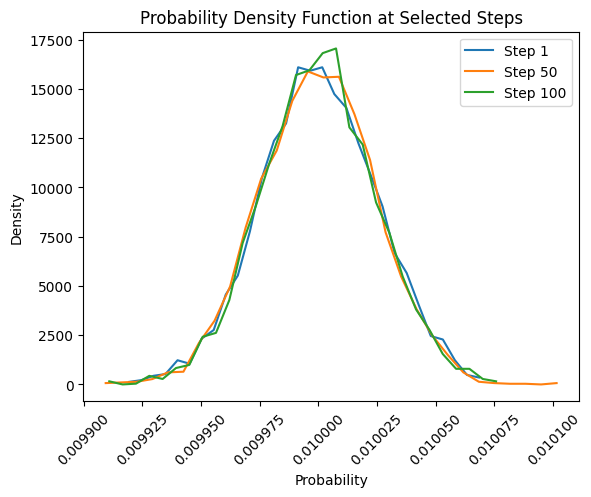

In [46]:
import numpy as np

# Step 1: Transpose the list of stochastic paths
# This creates a list of 100 elements, where each element is a list of probabilities for that step across all paths.
all_paths = np.array(stochastic_paths_df["stochastic_paths"].tolist())
transposed_paths = (
    all_paths.T
)  # Transpose so each row represents a step across all paths

# Step 2: Plot the PDF for each step
steps_to_plot = [
    0,
    49,
    99,
]  # For example, plot the PDF for the first, middle, and last step
for step in steps_to_plot:
    probabilities = transposed_paths[step]

    # Compute the histogram
    density, bins = np.histogram(probabilities, bins=30, density=True)
    # Compute bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Plot the PDF
    plt.plot(bin_centers, density, label=f"Step {step + 1}")

plt.xlabel("Probability")
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.ylabel("Density")
plt.title("Probability Density Function at Selected Steps")
plt.legend()
plt.show()